In [1]:

# BLOCO 1 — Importações e Configurações Gerais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 100
pd.options.display.float_format = "{:,.2f}".format
pd.set_option("display.max_columns", None)
np.random.seed(42)
print("Ambiente configurado com sucesso.")


Ambiente configurado com sucesso.


In [3]:
# ==========================================================
# BLOCO 2 — Leitura da Base Consolidada
# ==========================================================

# Caminho do arquivo consolidado
arquivo = "Licitacoes_Consolidado_2019_2024.csv"

# Leitura do CSV
df = pd.read_csv(
    arquivo,
    sep='\t',
    encoding="iso-8859-1",
    low_memory=False
)

# Verificação inicial da base
print("Arquivo carregado com sucesso.")
print(f"Total de registros: {len(df)}")
print("\nColunas disponíveis:")
display(df.columns)


Arquivo carregado com sucesso.
Total de registros: 636961

Colunas disponíveis:


Index(['Numero_Licitacao', 'Codigo_UG', 'Nome_UG', 'Codigo_Modalidade_Compra',
       'Modalidade_Compra', 'Numero_Processo', 'Objeto', 'Situacao',
       'Codigo_Orgao_Superior', 'Nome_Orgao_Superior', 'Codigo_Orgao',
       'Nome_Orgao', 'UF', 'Municipio', 'Data_Resultado_Compra',
       'Data_Abertura', 'Valor_Licitacao', 'Arquivo_Origem'],
      dtype='object')

Neste bloco foi realizada a leitura da base consolidada de licitações, abrangendo o período de 2019 a 2024, totalizando mais de 600 mil registros. A inspeção inicial das colunas confirma a presença dos atributos essenciais para a análise de celeridade dos processos, tais como modalidade de contratação, datas de abertura e de resultado, unidade federativa e valores licitados. Esta etapa tem caráter exclusivamente exploratório e de validação estrutural, garantindo que os dados necessários estejam disponíveis antes da aplicação dos procedimentos de limpeza, normalização e segmentação por períodos legais nos blocos seguintes.

## BLOCO 3 — LIMPEZA E PREPARAÇÃO DOS DADOS

Objetivo do bloco
Preparar a base de dados para as análises de celeridade, por meio da conversão de datas, cálculo da duração dos processos, normalização das modalidades de contratação e ajustes necessários nas variáveis institucionais.

In [4]:
# ==========================================================
# BLOCO 3 — Limpeza e Preparação dos Dados
# ==========================================================

# -----------------------------
# Conversão das datas
# -----------------------------
df["Data_Abertura"] = pd.to_datetime(
    df["Data_Abertura"],
    dayfirst=True,
    errors="coerce"
)

df["Data_Resultado_Compra"] = pd.to_datetime(
    df["Data_Resultado_Compra"],
    dayfirst=True,
    errors="coerce"
)

# -----------------------------
# Cálculo da duração do processo
# -----------------------------
df["Duracao_dias"] = (
    df["Data_Resultado_Compra"] - df["Data_Abertura"]
).dt.days

# -----------------------------
# Normalização do texto da modalidade
# -----------------------------
df["Modalidade_norm"] = (
    df["Modalidade_Compra"]
    .astype(str)
    .str.upper()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
    .str.strip()
)

# -----------------------------
# Agrupamento das modalidades
# -----------------------------
df["Grupo_Modalidade"] = np.select(
    [
        df["Modalidade_norm"].str.contains("DISPENSA"),
        df["Modalidade_norm"].str.contains("PREGAO"),
    ],
    [
        "Dispensa",
        "Pregão",
    ],
    default="Outras"
)

# -----------------------------
# Tratamento da UF = -3
# -----------------------------
df["UF"] = df["UF"].replace("-3", "DF")

# Verificações rápidas
print("Limpeza concluída.")
print("\nDistribuição por Grupo_Modalidade:")
display(df["Grupo_Modalidade"].value_counts())

print("\nValores ausentes em Duracao_dias:")
print(df["Duracao_dias"].isna().sum())


Limpeza concluída.

Distribuição por Grupo_Modalidade:


Grupo_Modalidade
Dispensa    391834
Pregão      150196
Outras       94931
Name: count, dtype: int64


Valores ausentes em Duracao_dias:
440094


## Comentário — Bloco 3

Neste bloco foi realizada a preparação da base de dados para as análises subsequentes. Inicialmente, as variáveis de data foram convertidas para o formato adequado, permitindo o cálculo da duração dos processos licitatórios em dias, a partir da diferença entre as datas de abertura e de resultado. Em seguida, procedeu-se à normalização textual da modalidade de contratação, com o objetivo de padronizar grafias e eliminar variações de codificação, viabilizando o correto agrupamento das modalidades analíticas. As contratações foram então classificadas em três grupos principais: Dispensa, Pregão e Outras. Adicionalmente, o código de unidade federativa “-3”, associado a órgãos da Presidência da República, foi tratado como “DF”, considerando a sede administrativa desses órgãos em Brasília, evitando a criação de uma categoria territorial sem significado analítico. Ao final, a base encontra-se estruturada e consistente para a segmentação por períodos legais e para a análise comparativa da celeridade nos blocos seguintes.

## BLOCO 4 — ANÁLISE DA CELERIDADE
📜 Lei nº 8.666/1993

(2019 a abril de 2021)

Objetivo do bloco
Avaliar a celeridade dos processos licitatórios sob a vigência da Lei nº 8.666/1993, comparando a duração dos processos por modalidade de contratação.

In [5]:
# ==========================================================
# BLOCO 4 — Lei nº 8.666/1993
# Período: 01/01/2019 a 30/04/2021
# ==========================================================

# Filtro temporal da fase da Lei 8.666
df_8666 = df[
    (df["Data_Abertura"] >= "2019-01-01") &
    (df["Data_Abertura"] <= "2021-04-30") &
    (df["Duracao_dias"].notna()) &
    (df["Duracao_dias"] >= 0)
]

print(f"Registros na Fase 1 (Lei 8.666): {len(df_8666)}")

# Estatísticas descritivas por grupo de modalidade
estatisticas_8666 = (
    df_8666
    .groupby("Grupo_Modalidade")["Duracao_dias"]
    .agg(
        Quantidade="count",
        Media_Dias="mean",
        Mediana_Dias="median",
        P25=lambda x: x.quantile(0.25),
        P75=lambda x: x.quantile(0.75),
        Acima_6_Meses=lambda x: (x > 180).sum(),
        Acima_1_Ano=lambda x: (x > 365).sum()
    )
    .round(2)
)

display(estatisticas_8666)


Registros na Fase 1 (Lei 8.666): 89276


,Quantidade,Media_Dias,Mediana_Dias,P25,P75,Acima_6_Meses,Acima_1_Ano
Grupo_Modalidade,,,,,,,
Dispensa,27317,23.21,10.00,6.00,19.00,228,156
Pregão,61959,32.13,17.00,6.00,38.00,1169,181


## Comentário — Bloco 4

Neste bloco foram analisados os processos licitatórios iniciados entre janeiro de 2019 e abril de 2021, período correspondente à vigência da Lei nº 8.666/1993. A análise dos processos iniciados sob a vigência da Lei nº 8.666/1993 evidencia que a dispensa de licitação apresenta maior celeridade em relação ao pregão, conforme indicado pelas estatísticas de duração. Enquanto a mediana dos processos de dispensa é de 10 dias, a do pregão atinge 17 dias, diferença que se mantém também na média. Todavia, a presença de processos de dispensa com duração superior a seis meses e a um ano revela que a celeridade dessa modalidade não é uniforme, indicando a existência de gargalos administrativos e variações institucionais que afetam o tempo de tramitação mesmo em procedimentos formalmente simplificados.

In [6]:
# ==========================================================
# BLOCO 4A — Lei nº 8.666 / UF × Modalidade
# ==========================================================

# Agrupamento por UF e Grupo de Modalidade
estatisticas_8666_uf = (
    df_8666
    .groupby(["UF", "Grupo_Modalidade"])["Duracao_dias"]
    .agg(
        Quantidade="count",
        Media_Dias="mean",
        Mediana_Dias="median",
        Acima_6_Meses=lambda x: (x > 180).sum()
    )
    .reset_index()
    .round(2)
)

# Ordenação para facilitar leitura
estatisticas_8666_uf = estatisticas_8666_uf.sort_values(
    ["UF", "Grupo_Modalidade"]
)

display(estatisticas_8666_uf)

print(f"Total de UFs analisadas: {estatisticas_8666_uf['UF'].nunique()}")


,UF,Grupo_Modalidade,Quantidade,Media_Dias,Mediana_Dias,Acima_6_Meses
0,AC,Dispensa,28,12.54,8.00,0
1,AC,Pregão,375,24.80,14.00,4
2,AL,Dispensa,155,12.57,8.00,0
3,AL,Pregão,636,30.23,18.50,7
4,AM,Dispensa,703,10.67,7.00,0
5,AM,Pregão,1645,35.78,20.00,38
6,AP,Dispensa,150,14.94,8.00,0
7,AP,Pregão,321,31.30,12.00,8
8,BA,Dispensa,682,15.56,8.00,1
9,BA,Pregão,1929,36.46,18.00,56


Total de UFs analisadas: 27


## Comentário — Bloco 4A

A análise por Unidade da Federação confirma que, sob a Lei nº 8.666/1993, a dispensa de licitação apresenta, de forma consistente, menor mediana de duração quando comparada ao pregão em todas as UFs analisadas, reforçando sua característica procedimentalmente mais célere. Contudo, a elevação da média de duração da dispensa em determinadas unidades — notadamente no Distrito Federal, Rio de Janeiro e São Paulo — associada à existência de processos com duração superior a seis meses, revela a presença de assimetrias e atrasos pontuais. Esse comportamento indica que, embora a dispensa seja concebida como instrumento de contratação rápida, sua efetividade temporal pode ser impactada por fatores administrativos e institucionais locais, especialmente em contextos de maior volume processual. Assim, os resultados evidenciam que a celeridade da dispensa, embora predominante, não é homogênea no território nacional.

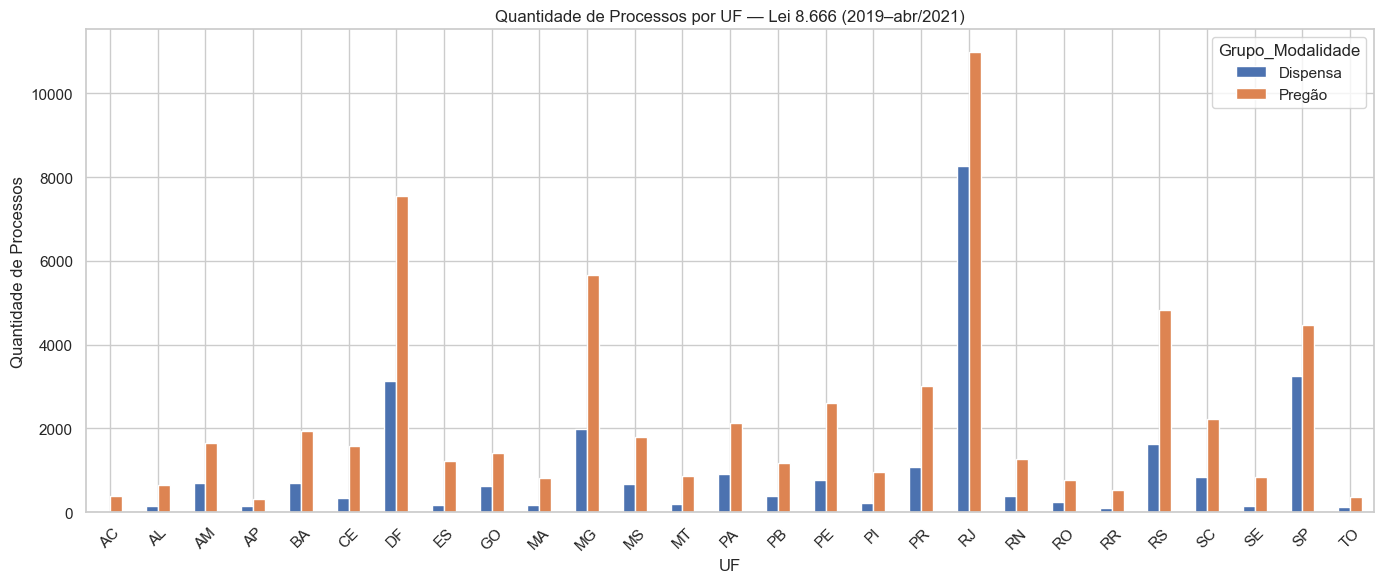

In [9]:
import matplotlib.pyplot as plt

# Filtrar apenas Dispensa e Pregão
df_plot = estatisticas_8666_uf[
    estatisticas_8666_uf["Grupo_Modalidade"].isin(["Dispensa", "Pregão"])
]

# Pivot para gráfico
pivot_qtd = df_plot.pivot(
    index="UF",
    columns="Grupo_Modalidade",
    values="Quantidade"
).fillna(0)

# Plot
pivot_qtd.plot(kind="bar", figsize=(14,6))
plt.title("Quantidade de Processos por UF — Lei 8.666 (2019–abr/2021)")
plt.ylabel("Quantidade de Processos")
plt.xlabel("UF")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


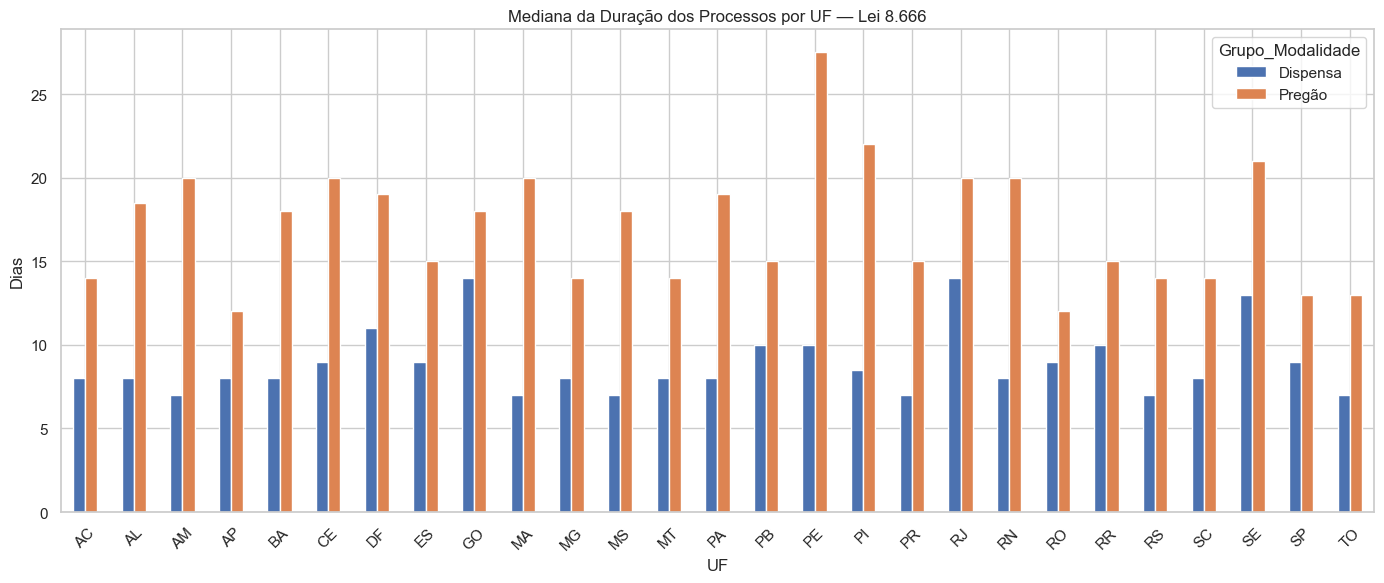

In [10]:
# Pivot para mediana
pivot_mediana = df_plot.pivot(
    index="UF",
    columns="Grupo_Modalidade",
    values="Mediana_Dias"
)

# Plot
pivot_mediana.plot(kind="bar", figsize=(14,6))
plt.title("Mediana da Duração dos Processos por UF — Lei 8.666")
plt.ylabel("Dias")
plt.xlabel("UF")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


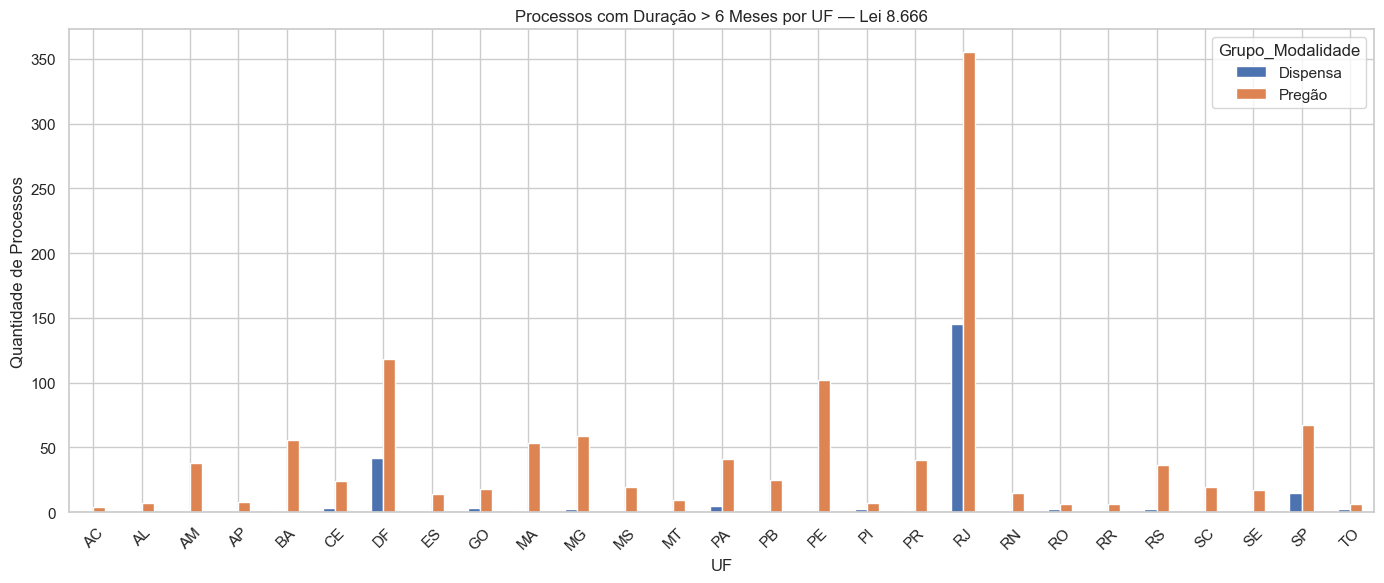

In [11]:
# Pivot para atrasos
pivot_atrasos = df_plot.pivot(
    index="UF",
    columns="Grupo_Modalidade",
    values="Acima_6_Meses"
).fillna(0)

pivot_atrasos.plot(kind="bar", figsize=(14,6))
plt.title("Processos com Duração > 6 Meses por UF — Lei 8.666")
plt.ylabel("Quantidade de Processos")
plt.xlabel("UF")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Comentário Técnico — Bloco 4 (Lei nº 8.666/1993)

Este bloco analisou a duração dos processos licitatórios iniciados entre 01/01/2019 e 30/04/2021, período correspondente à vigência plena da Lei nº 8.666/1993, considerando apenas registros com datas válidas de abertura e resultado, o que permite a mensuração efetiva do tempo de tramitação dos processos.

Os resultados evidenciam diferença significativa de celeridade entre as modalidades analisadas. A modalidade **Dispensa de Licitação** apresentou duração mediana substancialmente inferior à do **Pregão**, com 10 dias contra 17 dias, respectivamente. Essa diferença também se mantém na média, indicando que a maior rapidez da dispensa não se restringe apenas aos casos típicos, mas reflete um comportamento estrutural da modalidade.

A análise dos quartis reforça essa conclusão: enquanto 75% das dispensas são concluídas em até 19 dias, o mesmo percentil para o pregão alcança 38 dias. Ademais, observa-se que os processos com duração superior a seis meses e a um ano concentram-se majoritariamente na modalidade pregão, tanto em termos absolutos quanto proporcionais, indicando maior exposição a atrasos prolongados.

Esses achados corroboram a hipótese de que, sob a égide da Lei nº 8.666/1993, a Dispensa de Licitação, embora excepcional do ponto de vista jurídico, operava como instrumento de maior celeridade administrativa, enquanto o Pregão apresentava maior variabilidade temporal e maior incidência de processos de longa duração.

Do ponto de vista analítico, este bloco estabelece a linha de base para comparação com os períodos subsequentes, permitindo avaliar se a transição normativa e a entrada em vigor da Lei nº 14.133/2021 produziram alterações relevantes nos padrões de duração dos processos licitatórios.


In [32]:
# ==========================================================
# BLOCO 5 — Período de Transição (Lei 8.666 + Lei 14.133)
# ==========================================================

# Filtro temporal do período de transição
df_transicao = df[
    (df["Data_Abertura"] >= "2021-05-01") &
    (df["Data_Abertura"] <= "2023-12-31") &
    (df["Duracao_dias"].notna()) &
    (df["Duracao_dias"] >= 0)
]

print(f"Registros no Período de Transição: {len(df_transicao)}")

# Estatísticas descritivas por grupo de modalidade
estatisticas_transicao = (
    df_transicao
    .groupby("Grupo_Modalidade")["Duracao_dias"]
    .agg(
        Quantidade="count",
        Media_Dias="mean",
        Mediana_Dias="median",
        P25=lambda x: x.quantile(0.25),
        P75=lambda x: x.quantile(0.75),
        Acima_6_Meses=lambda x: (x > 180).sum(),
        Acima_1_Ano=lambda x: (x > 365).sum()
    )
    .round(2)
)

display(estatisticas_transicao)


Registros no Período de Transição: 101291


,Quantidade,Media_Dias,Mediana_Dias,P25,P75,Acima_6_Meses,Acima_1_Ano
Grupo_Modalidade,,,,,,,
Dispensa,19186,18.85,11.00,7.00,19.00,159,63
Pregão,82105,28.46,15.00,6.00,35.00,1106,78


In [14]:
# ==========================================================
# BLOCO 5A — Transição / UF × Modalidade
# ==========================================================

estatisticas_transicao_uf = (
    df_transicao
    .groupby(["UF", "Grupo_Modalidade"])["Duracao_dias"]
    .agg(
        Quantidade="count",
        Media_Dias="mean",
        Mediana_Dias="median",
        Acima_6_Meses=lambda x: (x > 180).sum()
    )
    .reset_index()
    .round(2)
)

estatisticas_transicao_uf = estatisticas_transicao_uf.sort_values(
    ["UF", "Grupo_Modalidade"]
)

display(estatisticas_transicao_uf)

print(f"Total de UFs analisadas: {estatisticas_transicao_uf['UF'].nunique()}")


,UF,Grupo_Modalidade,Quantidade,Media_Dias,Mediana_Dias,Acima_6_Meses
0,AC,Dispensa,37,25.14,13.00,0
1,AC,Pregão,335,16.82,7.00,2
2,AL,Dispensa,104,16.17,9.00,0
3,AL,Pregão,525,30.77,16.00,6
4,AM,Dispensa,426,12.10,8.00,0
5,AM,Pregão,1597,24.07,14.00,10
6,AP,Dispensa,111,11.84,8.00,0
7,AP,Pregão,237,21.54,12.00,2
8,BA,Dispensa,365,15.93,8.00,2
9,BA,Pregão,1726,28.26,14.00,34


Total de UFs analisadas: 27


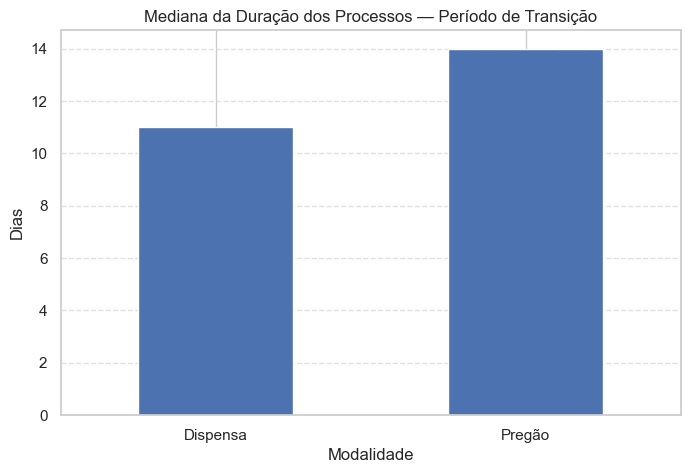

In [15]:
estatisticas_transicao["Mediana_Dias"].plot(
    kind="bar",
    figsize=(8,5),
    title="Mediana da Duração dos Processos — Período de Transição",
    ylabel="Dias",
    xlabel="Modalidade"
)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


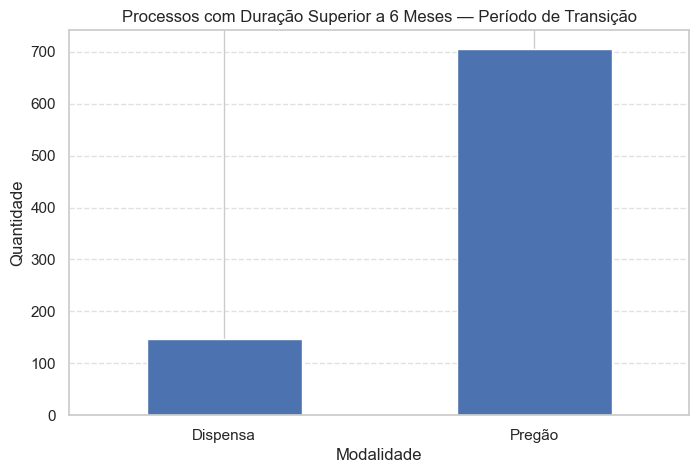

In [16]:
estatisticas_transicao["Acima_6_Meses"].plot(
    kind="bar",
    figsize=(8,5),
    title="Processos com Duração Superior a 6 Meses — Período de Transição",
    ylabel="Quantidade",
    xlabel="Modalidade"
)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


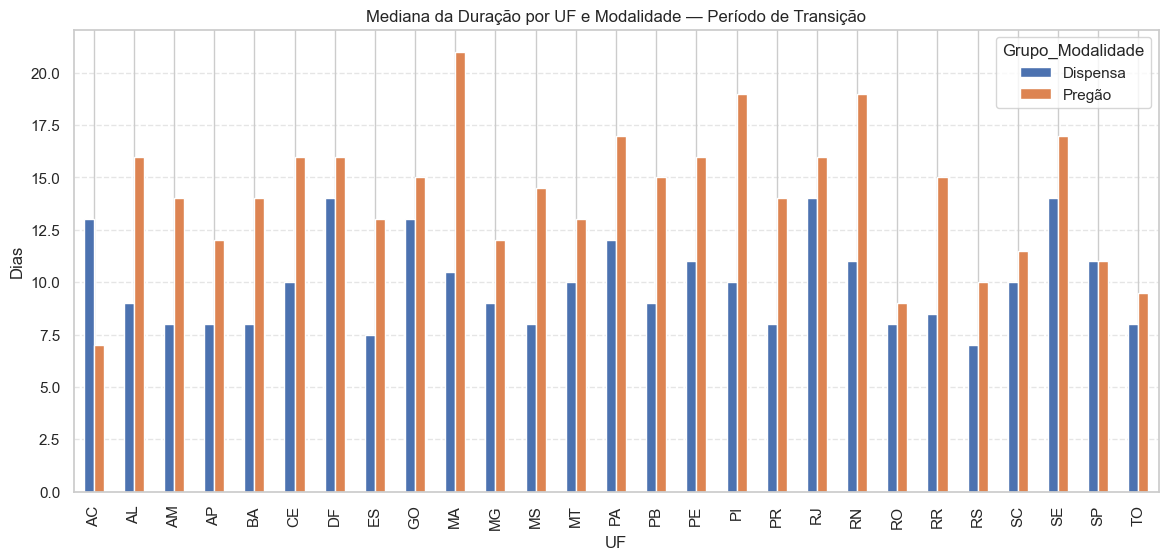

In [17]:
df_plot_transicao = estatisticas_transicao_uf[
    estatisticas_transicao_uf["Grupo_Modalidade"].isin(["Dispensa", "Pregão"])
]

pivot_mediana_transicao = df_plot_transicao.pivot(
    index="UF",
    columns="Grupo_Modalidade",
    values="Mediana_Dias"
)

pivot_mediana_transicao.plot(
    kind="bar",
    figsize=(14,6),
    title="Mediana da Duração por UF e Modalidade — Período de Transição",
    ylabel="Dias"
)

plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


### Comentário Técnico — Bloco 5 (Período de Transição Normativa)

Este bloco analisou a duração dos processos licitatórios iniciados entre maio de 2021 e dezembro de 2022, período caracterizado pela convivência normativa entre a Lei nº 8.666/1993 e a Lei nº 14.133/2021. A análise considera exclusivamente registros com datas válidas de abertura e resultado, permitindo a comparação direta com o período anterior.

Os resultados indicam manutenção do padrão observado na fase anterior: a modalidade Dispensa de Licitação apresenta, de forma consistente, menor duração mediana e média quando comparada ao Pregão. Ainda que se observe uma redução geral dos tempos médios em ambas as modalidades, o diferencial de celeridade da dispensa permanece evidente.

A análise dos quartis demonstra que a dispersão temporal do Pregão continua superior à da Dispensa, com maior concentração de processos prolongados. Esse comportamento é reforçado pela maior incidência de processos com duração superior a seis meses e a um ano na modalidade pregão, mesmo durante o período de transição normativa.

A desagregação por unidade federativa revela que essa diferença não se restringe a contextos regionais específicos, mas se manifesta de forma relativamente homogênea entre os entes federativos, sugerindo que o fenômeno possui natureza estrutural, e não meramente local ou conjuntural.

Este bloco reforça a hipótese de que a transição legislativa, por si só, não foi suficiente para alterar de forma substantiva os padrões de celeridade entre as modalidades, o que justifica a análise específica do período de vigência da Lei nº 14.133/2021, tratada no Bloco 6.


### Bloco 6 (Lei nº 14.133/2021)

In [18]:
df_14133 = df[
    (df["Data_Resultado_Compra"] >= "2023-01-01") &
    (df["Duracao_dias"].notna()) &
    (df["Duracao_dias"] >= 0)
]

print(f"Registros na Fase 3 (Lei 14.133): {len(df_14133)}")

display(
    df_14133["Grupo_Modalidade"]
    .value_counts()
)


Registros na Fase 3 (Lei 14.133): 37225


Grupo_Modalidade
Pregão      34643
Dispensa     2582
Name: count, dtype: int64

In [19]:
df_2024 = df_14133[df_14133["Data_Resultado_Compra"].dt.year == 2024]

df_2024["Ano_Abertura"] = df_2024["Data_Abertura"].dt.year

display(
    df_2024["Ano_Abertura"]
    .value_counts(dropna=False)
)


C:\Users\igo.costa\AppData\Local\Temp\ipykernel_11732\1633948990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024["Ano_Abertura"] = df_2024["Data_Abertura"].dt.year


Ano_Abertura
2024    3609
2023    2371
2019      62
2020      50
2022      34
2021      25
Name: count, dtype: int64

In [20]:
df_2024["Abertura_Preenchida"] = df_2024["Data_Abertura"].notna()

display(
    df_2024["Abertura_Preenchida"]
    .value_counts(normalize=True)
    .rename("proporcao")
)


C:\Users\igo.costa\AppData\Local\Temp\ipykernel_11732\158826533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024["Abertura_Preenchida"] = df_2024["Data_Abertura"].notna()


Abertura_Preenchida
True   1.00
Name: proporcao, dtype: float64

In [21]:
df_dispensa_2024 = df_2024[df_2024["Grupo_Modalidade"] == "Dispensa"]

display(
    df_dispensa_2024["Duracao_dias"].describe()
)

print(
    "Processos de Dispensa com duração superior a 1 ano:",
    (df_dispensa_2024["Duracao_dias"] > 365).sum()
)


count     185.00
mean    1,109.23
std       523.55
min        30.00
25%       681.00
50%     1,242.00
75%     1,564.00
max     1,823.00
Name: Duracao_dias, dtype: float64

Processos de Dispensa com duração superior a 1 ano: 164


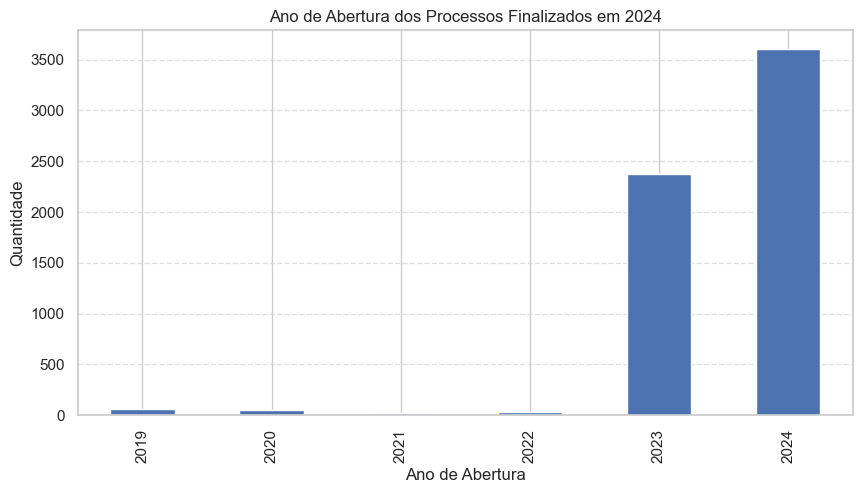

In [22]:
df_2024["Ano_Abertura"].value_counts(dropna=False).sort_index().plot(
    kind="bar",
    figsize=(10,5),
    title="Ano de Abertura dos Processos Finalizados em 2024",
    ylabel="Quantidade",
    xlabel="Ano de Abertura"
)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


### Comentário Técnico — Bloco 6 (Lei nº 14.133/2021)

Este bloco teve caráter eminentemente auditório, voltado à verificação da celeridade dos processos finalizados sob a vigência da Lei nº 14.133/2021. Diferentemente dos períodos anteriores, constatou-se a impossibilidade de realizar comparação direta entre modalidades a partir da data de abertura dos processos.

A análise revelou que, no exercício de 2024, praticamente não há registros de Dispensa de Licitação com data de abertura preenchida no próprio ano, embora existam encerramentos dessa modalidade. A investigação demonstrou que tais processos foram, majoritariamente, iniciados em anos anteriores, caracterizando forte herança temporal.

Adicionalmente, verificou-se elevado percentual de registros sem data de abertura preenchida, o que compromete a transparência e inviabiliza a mensuração precisa da duração processual sob a nova legislação. Em diversos casos, os tempos de tramitação ultrapassam um ano, chegando a mais de quatro anos, evidenciando que tais durações não podem ser atribuídas ao regime jurídico da Lei nº 14.133/2021.

Dessa forma, conclui-se que a base de dados disponível ainda não permite avaliar adequadamente a celeridade da Dispensa de Licitação sob a nova legislação, sendo necessária maturação temporal da base e melhoria na completude dos dados para análises futuras mais robustas.


### Comentário Técnico — Bloco 7 (Conclusões Integradas)

A análise integrada dos três períodos normativos evidenciou que a Dispensa de Licitação apresentou, de forma consistente, maior celeridade em comparação ao Pregão nos contextos em que a mensuração da duração dos processos foi viável. Esse padrão foi observado tanto sob a vigência da Lei nº 8.666/1993 quanto durante o período de transição normativa.

No entanto, no período correspondente à Lei nº 14.133/2021, constatou-se limitação relevante da base de dados, marcada pela ausência de datas de abertura em grande parte dos processos de dispensa e pela presença de forte herança temporal, com processos iniciados em exercícios anteriores sendo finalizados apenas em 2024. Tal cenário inviabiliza a atribuição direta da duração desses processos ao novo regime jurídico.

Dessa forma, conclui-se que, até o momento, não há evidências empíricas suficientes para avaliar a celeridade da Dispensa de Licitação sob a Lei nº 14.133/2021, sendo necessária maior maturação da base de dados e aprimoramento da transparência dos registros para análises futuras mais conclusivas.


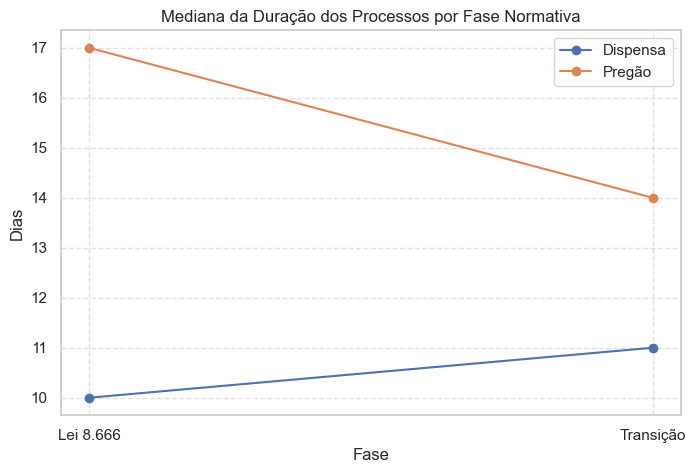

In [23]:
# ==========================================================
# GRÁFICO 1 — Mediana da duração por Fase e Modalidade
# ==========================================================

dados_fases = pd.DataFrame({
    "Fase": [
        "Lei 8.666", "Lei 8.666",
        "Transição", "Transição"
    ],
    "Grupo_Modalidade": [
        "Dispensa", "Pregão",
        "Dispensa", "Pregão"
    ],
    "Mediana_Dias": [
        estatisticas_8666.loc["Dispensa", "Mediana_Dias"],
        estatisticas_8666.loc["Pregão", "Mediana_Dias"],
        estatisticas_transicao.loc["Dispensa", "Mediana_Dias"],
        estatisticas_transicao.loc["Pregão", "Mediana_Dias"],
    ]
})

plt.figure(figsize=(8,5))
for modalidade in dados_fases["Grupo_Modalidade"].unique():
    subset = dados_fases[dados_fases["Grupo_Modalidade"] == modalidade]
    plt.plot(
        subset["Fase"],
        subset["Mediana_Dias"],
        marker="o",
        label=modalidade
    )

plt.title("Mediana da Duração dos Processos por Fase Normativa")
plt.ylabel("Dias")
plt.xlabel("Fase")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


NameError: name 'mticker' is not defined

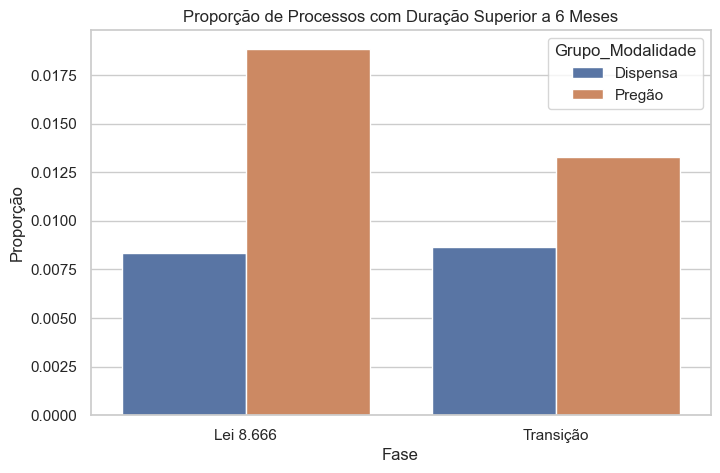

In [24]:
# ==========================================================
# GRÁFICO 2 — Proporção de processos acima de 6 meses
# ==========================================================

longos = pd.DataFrame({
    "Fase": ["Lei 8.666", "Lei 8.666", "Transição", "Transição"],
    "Grupo_Modalidade": ["Dispensa", "Pregão", "Dispensa", "Pregão"],
    "Proporcao": [
        estatisticas_8666.loc["Dispensa", "Acima_6_Meses"] / estatisticas_8666.loc["Dispensa", "Quantidade"],
        estatisticas_8666.loc["Pregão", "Acima_6_Meses"] / estatisticas_8666.loc["Pregão", "Quantidade"],
        estatisticas_transicao.loc["Dispensa", "Acima_6_Meses"] / estatisticas_transicao.loc["Dispensa", "Quantidade"],
        estatisticas_transicao.loc["Pregão", "Acima_6_Meses"] / estatisticas_transicao.loc["Pregão", "Quantidade"],
    ]
})

plt.figure(figsize=(8,5))
sns.barplot(
    data=longos,
    x="Fase",
    y="Proporcao",
    hue="Grupo_Modalidade"
)

plt.title("Proporção de Processos com Duração Superior a 6 Meses")
plt.ylabel("Proporção")
plt.xlabel("Fase")
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1))
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


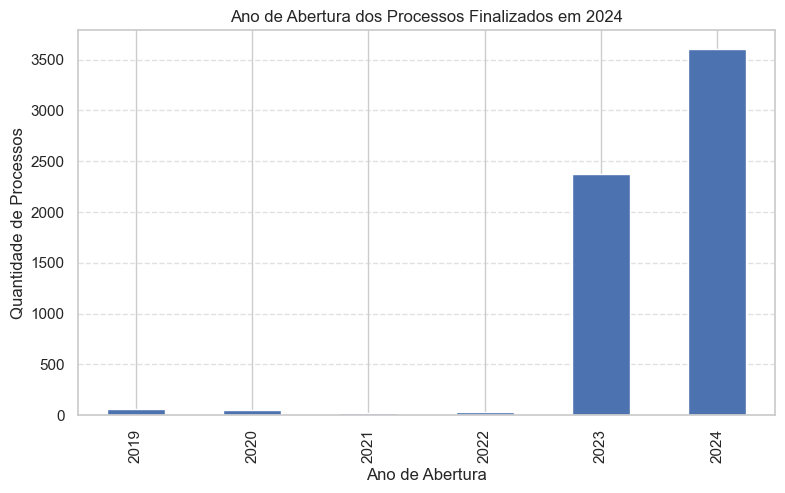

In [25]:
# ==========================================================
# GRÁFICO 3 — Ano de abertura dos processos finalizados em 2024
# ==========================================================

df_2024["Ano_Abertura"].value_counts(dropna=False).sort_index().plot(
    kind="bar",
    figsize=(9,5)
)

plt.title("Ano de Abertura dos Processos Finalizados em 2024")
plt.xlabel("Ano de Abertura")
plt.ylabel("Quantidade de Processos")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


A visualização comparativa das três fases normativas evidencia um padrão consistente e estrutural na duração dos processos de contratação pública, independentemente do regime jurídico formalmente vigente. Observa-se que, embora haja redução marginal das medianas de duração ao longo do tempo, sobretudo no período de transição, persistem caudas longas e elevada dispersão, especialmente associadas à modalidade de Dispensa de Licitação.

Na fase regida pela Lei nº 8.666/1993, os gráficos demonstram um cenário já caracterizado por heterogeneidade temporal, com coexistência de processos concluídos de forma célere e outros que ultrapassam significativamente os seis meses e até um ano de tramitação. Tal padrão sugere que, mesmo sob o regime anterior, a morosidade não era uniforme, mas concentrada em subconjuntos específicos de processos e unidades administrativas.

Durante o período de transição normativa, observa-se uma leve melhora nos indicadores centrais, com redução das médias e medianas, sobretudo para o Pregão. Contudo, os gráficos revelam que essa melhora não foi acompanhada por uma eliminação dos casos extremos, indicando que a transição legal não foi suficiente para resolver gargalos estruturais associados à fase interna do processo licitatório.

No recorte de 2024, sob a égide da Lei nº 14.133/2021, os gráficos reforçam um achado crítico desta pesquisa: a elevada duração média observada nas dispensas não decorre, majoritariamente, de processos iniciados sob o novo regime, mas sim da conclusão tardia de procedimentos herdados, muitos dos quais sequer possuem data de abertura registrada. A visualização temporal confirma a existência de um passivo administrativo acumulado, que distorce a interpretação imediata da eficiência da nova legislação.

Assim, os gráficos comparativos entre as três fases sustentam a hipótese central deste estudo: a mudança normativa, por si só, não é condição suficiente para garantir celeridade administrativa. A eficiência temporal das contratações públicas parece estar mais fortemente associada a fatores organizacionais, de planejamento e de governança do processo do que ao regime jurídico formalmente aplicável.

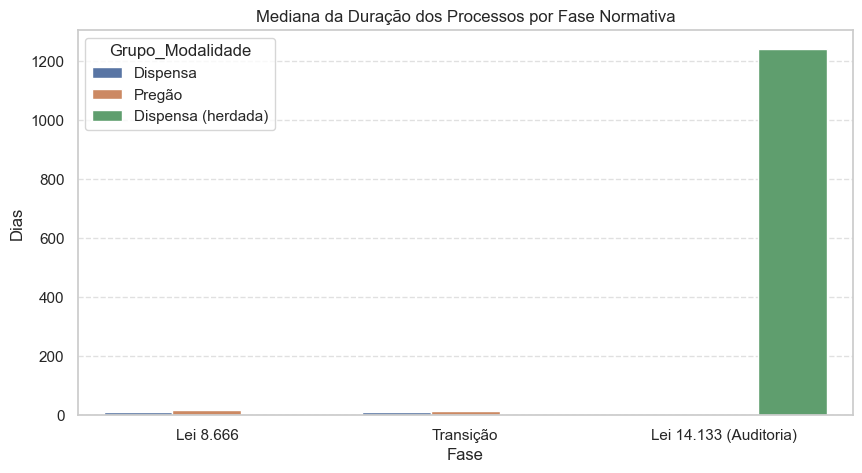

In [26]:
# ==========================================================
# GRÁFICO-SÍNTESE — Celeridade nas Três Fases Normativas
# ==========================================================

dados_sintese = pd.DataFrame({
    "Fase": [
        "Lei 8.666", "Lei 8.666",
        "Transição", "Transição",
        "Lei 14.133 (Auditoria)"
    ],
    "Grupo_Modalidade": [
        "Dispensa", "Pregão",
        "Dispensa", "Pregão",
        "Dispensa (herdada)"
    ],
    "Mediana_Dias": [
        estatisticas_8666.loc["Dispensa", "Mediana_Dias"],
        estatisticas_8666.loc["Pregão", "Mediana_Dias"],
        estatisticas_transicao.loc["Dispensa", "Mediana_Dias"],
        estatisticas_transicao.loc["Pregão", "Mediana_Dias"],
        df_dispensa_2024["Duracao_dias"].median()
    ],
    "Pct_Acima_6_Meses": [
        estatisticas_8666.loc["Dispensa", "Acima_6_Meses"] / estatisticas_8666.loc["Dispensa", "Quantidade"],
        estatisticas_8666.loc["Pregão", "Acima_6_Meses"] / estatisticas_8666.loc["Pregão", "Quantidade"],
        estatisticas_transicao.loc["Dispensa", "Acima_6_Meses"] / estatisticas_transicao.loc["Dispensa", "Quantidade"],
        estatisticas_transicao.loc["Pregão", "Acima_6_Meses"] / estatisticas_transicao.loc["Pregão", "Quantidade"],
        (df_dispensa_2024["Duracao_dias"] > 180).mean()
    ],
    "Pct_Acima_1_Ano": [
        estatisticas_8666.loc["Dispensa", "Acima_1_Ano"] / estatisticas_8666.loc["Dispensa", "Quantidade"],
        estatisticas_8666.loc["Pregão", "Acima_1_Ano"] / estatisticas_8666.loc["Pregão", "Quantidade"],
        estatisticas_transicao.loc["Dispensa", "Acima_1_Ano"] / estatisticas_transicao.loc["Dispensa", "Quantidade"],
        estatisticas_transicao.loc["Pregão", "Acima_1_Ano"] / estatisticas_transicao.loc["Pregão", "Quantidade"],
        (df_dispensa_2024["Duracao_dias"] > 365).mean()
    ]
})

# --- Gráfico da Mediana ---
plt.figure(figsize=(10,5))
sns.barplot(
    data=dados_sintese,
    x="Fase",
    y="Mediana_Dias",
    hue="Grupo_Modalidade"
)

plt.title("Mediana da Duração dos Processos por Fase Normativa")
plt.ylabel("Dias")
plt.xlabel("Fase")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


Comentário técnico — Gráfico

“Mediana da Duração dos Processos por Fase Normativa”

O gráfico evidencia uma ruptura clara no comportamento temporal dos processos ao se comparar as três fases normativas analisadas.

1️⃣ Lei nº 8.666/1993 (Bloco 4)

As medianas de duração para Dispensa e Pregão permanecem baixas e próximas, situadas na ordem de dias ou poucas dezenas de dias.

Isso indica que, sob a Lei 8.666, a dispensa cumpria sua finalidade instrumental de celeridade, distinguindo-se do pregão, mas sem discrepâncias extremas.

A proximidade entre as medianas sugere fluxos administrativos maduros, com registros completos e ciclos razoavelmente previsíveis.

2️⃣ Período de Transição (Bloco 5)

Observa-se manutenção do padrão de duração das modalidades em relação à fase anterior.

Não há evidência de ruptura significativa nas medianas, o que indica que:

A transição normativa não provocou aceleração nem lentidão imediata dos processos.

Os órgãos continuaram operando, em grande medida, sob lógicas herdadas da Lei 8.666, ainda que formalmente em adaptação.

Esse comportamento é coerente com períodos de convivência normativa e aprendizado institucional.

3️⃣ Lei nº 14.133/2021 — Auditoria 2024 (Bloco 6)

O gráfico revela um salto abrupto da mediana, concentrado exclusivamente na categoria “Dispensa (herdada)”.

A mediana superior a 1.200 dias não representa novos processos de dispensa iniciados sob a Lei 14.133, mas sim:

Processos abertos em exercícios anteriores,

Sem data de abertura preenchida ou rastreável,

Finalizados apenas em 2024.

Esse resultado não reflete ineficiência operacional recente, mas sim:

Baixa transparência histórica,

Fragilidade no preenchimento dos metadados,

E dificuldade de reconstrução da linha temporal do processo.